In [2]:
!pip install gdown
import gdown
#!gdown --id 1Dw3yOdKEEsKdc42isVt118AofD3wE-qH -O images.zip
#!unzip images.zip
!gdown --id 1CFfRd1A_obw6YMhGXktNuyX_hFr8L9AH -O style.zip
!unzip style.zip

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-3.12.2-py3-none-any.whl size=9681 sha256=78320fb297aedd37230fbbd7f8d7f10f8db47ff573d158cb417f2afee9b889c4
  Stored in directory: /root/.cache/pip/wheels/ba/e0/7e/726e872a53f7358b4b96a9975b04e98113b005cd8609a63abc
Successfully built gdown
Downloading...
From: https://drive.google.com/uc?id=1CFfRd1A_obw6YMhGXktNuyX_hFr8L9AH
To: /kaggle/working/style.zip
100%|███████████████████████████████████████| 1.66M/1.66M [00:00<00:00, 106MB/s]
Archive:  style.zip
  inflating: style/01_candy.jpg      
  inflating: style/02_cezanne.jpg    
  inflating: style/03_mosaic.jpg     
  inflating: style/04_picasso.jpg    
  inflating: style/05_rain-princess-cropped.jpg  
  inflating: style/06_starry-night-cropped.jpg  
  inflating: style/07_udnie.jpg      
  inflating: style/08_waterfall.jpg  
  inflating: style/09_kandinsky.jpg  
  inflating:

In [3]:
from collections import namedtuple

import torch
import torchvision.models.vgg as vgg

LossOutput = namedtuple(
    "LossOutput", ["relu1", "relu2", "relu3", "relu4", "relu5"])


class LossNetwork(torch.nn.Module):
    """Reference:
        https://discuss.pytorch.org/t/how-to-extract-features-of-an-image-from-a-trained-model/119/3
    """

    def __init__(self):
        super(LossNetwork, self).__init__()
        self.vgg_layers = vgg.vgg19(pretrained=True).features
        self.layer_name_mapping = {
            '3': "relu1",
            '8': "relu2",
            '17': "relu3",
            '26': "relu4",
            '35': "relu5",
        }

    def forward(self, x):
        output = {}
        for name, module in self.vgg_layers._modules.items():
            x = module(x)
            if name in self.layer_name_mapping:
                output[self.layer_name_mapping[name]] = x
        return LossOutput(**output)

In [4]:
import torch


class TransformerNet(torch.nn.Module):
    def __init__(self):
        super(TransformerNet, self).__init__()
        # Initial convolution layers
        self.conv1 = ConvLayer(3, 32, kernel_size=9, stride=1)
        self.in1 = torch.nn.InstanceNorm2d(32, affine=True)     
        self.conv2 = ConvLayer(32, 64, kernel_size=3, stride=2)
        self.in2 = torch.nn.InstanceNorm2d(64, affine=True)
        self.conv3 = ConvLayer(64, 128, kernel_size=3, stride=2)
        self.in3 = torch.nn.InstanceNorm2d(128, affine=True)
        # Residual layers
        self.res1 = ResidualBlock(128)
        self.res2 = ResidualBlock(128)
        self.res3 = ResidualBlock(128)
        self.res4 = ResidualBlock(128)
        self.res5 = ResidualBlock(128)
        # Upsampling Layers
        self.deconv1 = UpsampleConvLayer(
            128, 64, kernel_size=3, stride=1, upsample=2)
        self.in4 = torch.nn.InstanceNorm2d(64, affine=True)
        self.deconv2 = UpsampleConvLayer(
            64, 32, kernel_size=3, stride=1, upsample=2)
        self.in5 = torch.nn.InstanceNorm2d(32, affine=True)
        self.deconv3 = ConvLayer(32, 3, kernel_size=9, stride=1)
        # Non-linearities
        self.relu = torch.nn.ReLU()

    def forward(self, X):
        y = self.relu(self.in1(self.conv1(X)))
        y = self.relu(self.in2(self.conv2(y)))
        y = self.relu(self.in3(self.conv3(y)))
        y = self.res1(y)
        y = self.res2(y)
        y = self.res3(y)
        y = self.res4(y)
        y = self.res5(y)
        y = self.relu(self.in4(self.deconv1(y)))
        y = self.relu(self.in5(self.deconv2(y)))
        y = self.deconv3(y)
        return y


class ConvLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ConvLayer, self).__init__()
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(
            in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out


class ResidualBlock(torch.nn.Module):
    """ResidualBlock
    introduced in: https://arxiv.org/abs/1512.03385
    recommended architecture: http://torch.ch/blog/2016/02/04/resnets.html
    """

    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in1 = torch.nn.InstanceNorm2d(channels, affine=True)
        self.conv2 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in2 = torch.nn.InstanceNorm2d(channels, affine=True)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.relu(self.in1(self.conv1(x)))
        out = self.in2(self.conv2(out))
        out = out + residual
        return out


class UpsampleConvLayer(torch.nn.Module):
    """UpsampleConvLayer
    Upsamples the input and then does a convolution. This method gives better results
    compared to ConvTranspose2d.
    ref: http://distill.pub/2016/deconv-checkerboard/
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None):
        super(UpsampleConvLayer, self).__init__()
        self.upsample = upsample
        if upsample:
            self.upsample_layer = torch.nn.Upsample(
                mode='nearest', scale_factor=upsample)
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(
            in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        x_in = x
        if self.upsample:
            x_in = self.upsample_layer(x_in)
        out = self.reflection_pad(x_in)
        out = self.conv2d(out)
        return out

In [5]:
import torch
from torch.nn import ModuleList, InstanceNorm2d

class TransformerMultiStyleNet(torch.nn.Module):
    def __init__(self, style_number = 1):
        super().__init__()
        # Initial convolution layers
        self.conv1 = ConvLayer(3, 32, kernel_size=9, stride=1)
        self.in1 = ModuleList([InstanceNorm2d(32, affine=True) for _ in range(style_number)])        
        self.conv2 = ConvLayer(32, 64, kernel_size=3, stride=2)
        self.in2 = ModuleList([InstanceNorm2d(64, affine=True) for _ in range(style_number)])  
        self.conv3 = ConvLayer(64, 128, kernel_size=3, stride=2)
        self.in3 = ModuleList([InstanceNorm2d(128, affine=True) for _ in range(style_number)])  
        # Residual layers
        self.res1 = ResidualMultiStyleBlock(128, style_number)
        self.res2 = ResidualMultiStyleBlock(128, style_number)
        self.res3 = ResidualMultiStyleBlock(128, style_number)
        self.res4 = ResidualMultiStyleBlock(128, style_number)
        self.res5 = ResidualMultiStyleBlock(128, style_number)
        # Upsampling Layers
        self.deconv1 = UpsampleConvLayer(
            128, 64, kernel_size=3, stride=1, upsample=2)
        self.in4 = ModuleList([InstanceNorm2d(64, affine=True) for _ in range(style_number)])  
        self.deconv2 = UpsampleConvLayer(
            64, 32, kernel_size=3, stride=1, upsample=2)
        self.in5 = ModuleList([InstanceNorm2d(32, affine=True) for _ in range(style_number)])  
        self.deconv3 = ConvLayer(32, 3, kernel_size=9, stride=1)
        # Non-linearities
        self.relu = torch.nn.ReLU()

    def forward(self, X, style):
        y = self.relu(self.in1[style](self.conv1(X)))
        y = self.relu(self.in2[style](self.conv2(y)))
        y = self.relu(self.in3[style](self.conv3(y)))
        y = self.res1(y, style)
        y = self.res2(y, style)
        y = self.res3(y, style)
        y = self.res4(y, style)
        y = self.res5(y, style)
        y = self.relu(self.in4[style](self.deconv1(y)))
        y = self.relu(self.in5[style](self.deconv2(y)))
        y = self.deconv3(y)
        return y


class ResidualMultiStyleBlock(torch.nn.Module):
    """ResidualBlock
    introduced in: https://arxiv.org/abs/1512.03385
    recommended architecture: http://torch.ch/blog/2016/02/04/resnets.html
    """

    def __init__(self, channels, style_number=1):
        super().__init__()
        self.conv1 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in1 = ModuleList([InstanceNorm2d(channels, affine=True) for _ in range(style_number)])  
        self.conv2 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in2 = ModuleList([InstanceNorm2d(channels, affine=True) for _ in range(style_number)])  
        self.relu = torch.nn.ReLU()

    def forward(self, x, style):
        residual = x
        out = self.relu(self.in1[style](self.conv1(x)))
        out = self.in2[style](self.conv2(out))
        out = out + residual
        return out



In [6]:
from torch import nn
import torch
from torchvision import models, transforms
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
from torch.nn import Sequential, ReLU, Conv2d, AvgPool2d, ReflectionPad2d,\
BatchNorm2d, InstanceNorm2d, UpsamplingNearest2d
from torch.nn import ConvTranspose2d as ConvT2d

class Pyramid(nn.Module):
  def __init__(self, mode=None):
    super().__init__()
    ratios = [32, 16, 8, 4, 2, 1]
    mode = 5
    if mode == 5:
        ratios = ratios[1:]
    self.stages = len(ratios)
    self.mode = mode
    do_inplace = False  # True
    self.downs = nn.ModuleList([ReLU()]*self.stages) #
    self.ups   = nn.ModuleList([ReLU()]*self.stages) #
    norm = InstanceNorm2d
    features = 8*1
    act = ReLU#nn.LeakyReLU #ReLU
    class down_com(nn.Module):
      def __init__(self, layer_number):
        super().__init__()
        self.layer = Sequential(
          AvgPool2d(ratios[layer_number], ratios[layer_number]),
          Conv2d(3, features, 3, padding=1, padding_mode='reflect'), norm(features), act(do_inplace),
          Conv2d(features, features, 3, padding=1, padding_mode='reflect'), norm(features), act(do_inplace),
          Conv2d(features, features, 1), norm(features), act(do_inplace),
          #norm(features)
        )
      
    #self.downsdown_com(0).layer)
     #self.downs[0] = down_com(0).layer  # Sequential(#norm(3),
        #*down_com(0).layer[:-1], UpsamplingNearest2d(scale_factor=2), norm(features))
    for layer_number in range(0, self.stages):
      self.downs[layer_number] = down_com(layer_number).layer
      #self.downs.append(down_com(layer_number).layer)
    
    class up_com(nn.Module):
      def __init__(self, features_num):
        super().__init__()
        self.layer = Sequential(
                norm(features_num),
                Conv2d(features_num, features_num, 3, padding=1, padding_mode='reflect'), norm(features_num), act(do_inplace),
                Conv2d(features_num, features_num, 3, padding=1, padding_mode='reflect'), norm(features_num), act(do_inplace),
                Conv2d(features_num, features_num, 1), norm(features_num), act(do_inplace),
                #UpsamplingNearest2d(scale_factor=2),
                
                #Conv2d(features_num, features_num, 3, padding=1, padding_mode='reflect'), norm(features_num), act(do_inplace),
                UpsamplingNearest2d(scale_factor=2),
                #Conv2d(features_num, features_num, 3, padding=1, padding_mode='reflect'), norm(features_num), act(do_inplace),
                )
        
    for layer_number in range(self.stages):
      features_num = (layer_number + 1)*features
      self.ups[layer_number] = up_com(features_num).layer
      #self.ups.append(up_com(features_num).layer)
    self.ups[layer_number] = Sequential(*self.ups[layer_number][:-1], Conv2d(features_num, 3, 1))
    
  def forward(self, image):
    last_out = None
    #image = self.initial_bn(image.clone())
    for stage in range(self.stages):
      #print(f'stage={stage}, {image.device}')
      
      cur_x = self.downs[stage](image.clone())
      #print('inp = ', image.shape, f'down({stage})=', cur_x.shape)
      tocat = [cur_x]
      if last_out is not None:
        tocat.append(last_out)
      #print(f'{[x.shape for x in tocat]}')
      cur_x = torch.cat(tocat, dim=1)
      last_out = self.ups[stage](cur_x) # del clone
      #print(cur_x.shape, last_out.shape)
    return last_out

In [7]:
import numpy as np
from torchvision import transforms


def gram_matrix(y):
    (b, ch, h, w) = y.size()
    features = y.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (h * w) # remove /ch
    return gram


def tensor_normalizer():
    return transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])


def recover_image(img):
    return (
        (
            img *
            np.array([0.229, 0.224, 0.225]).reshape((1, 3, 1, 1)) +
            np.array([0.485, 0.456, 0.406]).reshape((1, 3, 1, 1))
        ).transpose(0, 2, 3, 1) *
        255.
    ).clip(0, 255).astype(np.uint8)

In [8]:

import time 

import matplotlib.pyplot as plt
import numpy as np
import torch
# For getting VGG model
import torchvision.models.vgg as vgg
import torch.utils.model_zoo as model_zoo
# Image transformation pipeline
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.optim import Adam
from torch.autograd import Variable
from PIL import Image, ImageFile
from tqdm import tqdm_notebook

'''from fast_neural_style.transformer_net import TransformerNet
from fast_neural_style.utils import (
    gram_matrix, recover_image, tensor_normalizer
)
from fast_neural_style.loss_network import LossNetwork
''' 
get_ipython().run_line_magic('matplotlib', 'inline')
ImageFile.LOAD_TRUNCATED_IMAGES = True


In [9]:
if False:
    SEED = 1080
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED)
        torch.set_default_tensor_type('torch.cuda.FloatTensor')
    else:
        torch.set_default_tensor_type('torch.FloatTensor')

if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    kwargs = {'num_workers': 4, 'pin_memory': True}
else:
    torch.set_default_tensor_type('torch.FloatTensor')
    kwargs = {}


In [34]:
IMAGE_SIZE = int(256*2)
BATCH_SIZE = 4
DATASET = "../input/coco2017/"
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE), 
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(), tensor_normalizer()])

In [35]:
# http://pytorch.org/docs/master/torchvision/datasets.html#imagefolder
train_dataset = datasets.ImageFolder(DATASET, transform)
# http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)


In [12]:
#torch.save(LossNetwork.state_dict(), './LossNet.pth')

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
with torch.no_grad():
    loss_network = LossNetwork()
    loss_network.to(device)
loss_network.eval()


LossNetwork(
  (vgg_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1

In [14]:
styles = sorted(Path('./style').glob('*.*'))


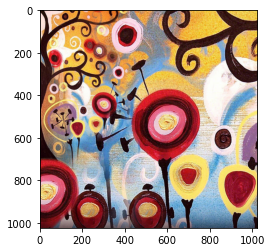

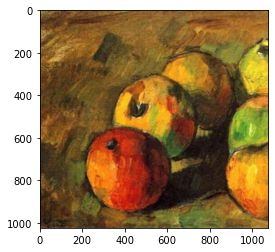

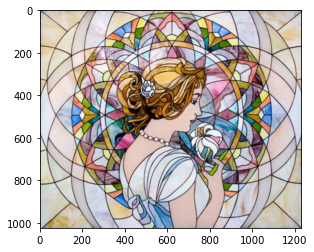

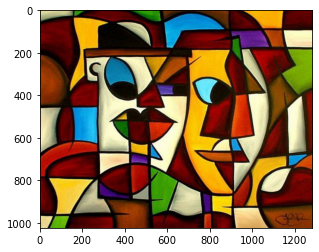

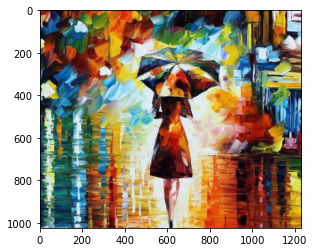

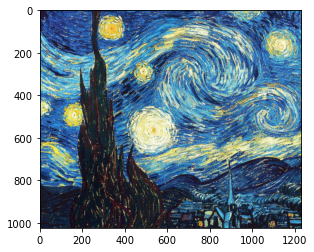

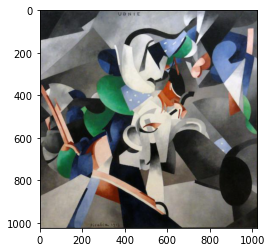

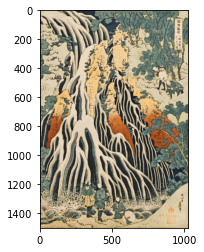

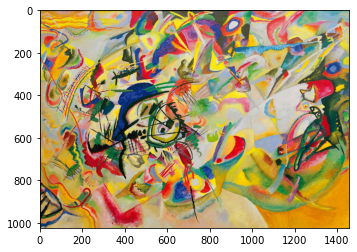

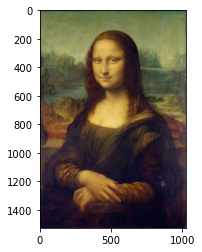

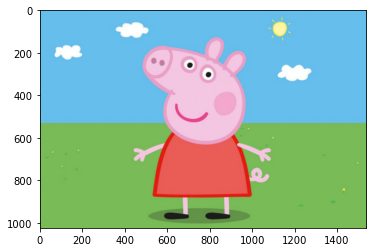

In [37]:

if False:
    STYLE_IMAGE = "./style/05_rain-princess-cropped.jpg.jpg"
    style_img = Image.open(STYLE_IMAGE).convert('RGB')
    with torch.no_grad():
        style_img_tensor = transforms.Compose([
            transforms.Resize(IMAGE_SIZE* 2),
            transforms.ToTensor(),
            tensor_normalizer()]
        )(style_img).unsqueeze(0)
        # assert np.sum(style_img - recover_image(style_img_tensor.numpy())[0].astype(np.uint8)) < 3 * style_img_tensor.size()[2] * style_img_tensor.size()[3]
        style_img_tensor = style_img_tensor.to(device)

    # http://pytorch.org/docs/master/notes/autograd.html#volatile
    with torch.no_grad():
        style_loss_features = loss_network(style_img_tensor)
        gram_style = [gram_matrix(y) for y in style_loss_features]
    plt.imshow(recover_image(style_img_tensor.cpu().numpy())[0])
else:
    gram_styles = []
    for sn, STYLE_IMAGE in enumerate(styles):
        if sn >= 100:
            break
        style_img = Image.open(STYLE_IMAGE).convert('RGB')
        with torch.no_grad():
            style_img_tensor = transforms.Compose([
                transforms.Resize(IMAGE_SIZE* 2),
                transforms.ToTensor(),
                tensor_normalizer()]
            )(style_img).unsqueeze(0)
            # assert np.sum(style_img - recover_image(style_img_tensor.numpy())[0].astype(np.uint8)) < 3 * style_img_tensor.size()[2] * style_img_tensor.size()[3]
            style_img_tensor = style_img_tensor.to(device)

        # http://pytorch.org/docs/master/notes/autograd.html#volatile
        with torch.no_grad():
            style_loss_features = loss_network(style_img_tensor)
            gram_styles.append([gram_matrix(y) for y in style_loss_features])
        plt.imshow(recover_image(style_img_tensor.cpu().numpy())[0])
        plt.show()
        style_num = len(gram_styles)


In [38]:
style_num

11

In [39]:
def save_debug_image(tensor_orig, tensor_transformed, filename):
    #assert tensor_orig.size() == tensor_transformed.size(), f'{tensor_orig.size()} != {tensor_transformed.size()}'
    result = Image.fromarray(recover_image(tensor_transformed.cpu().numpy())[0])
    orig = Image.fromarray(recover_image(tensor_orig.cpu().numpy())[0])
    new_im = Image.new('RGB', (result.size[0] * 2 + 5, result.size[1]))
    new_im.paste(orig, (0,0))
    new_im.paste(result, (result.size[0] + 5,0))
    new_im.save(filename)



In [40]:
get_ipython().run_line_magic('mkdir', '-p ./debug')


In [41]:
def rgrad_params_num(model, model_name=None):
    rgpn = 0
    for p in model.parameters():
        if isinstance(p, BatchNorm2d):
          print(f'bn: {p}')
          break
        if p.requires_grad:
            rgpn += p.numel()
    if model_name:
        print(f'{model_name} req to teach {rgpn} params')
    return rgpn

def turn_req_grad_for_instance(model, inst, req_grad=True, modified_layers=0, verbosity=1):
  for layer in model.children():
    if isinstance(layer, Sequential) or isinstance(layer, nn.ModuleList):
      modified_layers += turn_req_grad_for_instance(layer, inst, req_grad, verbosity=0)
    elif isinstance(layer, inst):
      layer.requires_grad_(req_grad)
      modified_layers += 1
  if verbosity:
    print(f'modified {modified_layers}')
  return modified_layers

def turn_req_grad(params, req_grad=True):
    for p in params:
        p.requires_grad = req_grad
        

In [20]:
transformer = TransformerMultiStyleNet(style_num) # TransformerNet() # Pyramid() # 
mse_loss = torch.nn.MSELoss()
# l1_loss = torch.nn.L1Loss()
transformer.to(device)

TransformerMultiStyleNet(
  (conv1): ConvLayer(
    (reflection_pad): ReflectionPad2d((4, 4, 4, 4))
    (conv2d): Conv2d(3, 32, kernel_size=(9, 9), stride=(1, 1))
  )
  (in1): ModuleList(
    (0): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (2): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (3): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (4): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (5): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (6): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (7): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (8): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, tr

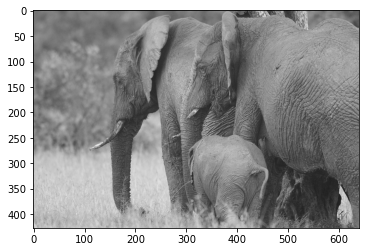

In [44]:
import glob
fnames = glob.glob(DATASET + 'val2017/val2017/'+r"/*.*")
#print(f'filenames = {len(fnames)}')
transformer = transformer.eval()
img_test = Image.open(fnames[np.random.randint(len(fnames))]).convert('L').convert('RGB')
plt.imshow(img_test)

transform = transforms.Compose([
                                
                                transforms.ToTensor(),
                                tensor_normalizer()])

img_test_tensor = transform(img_test).unsqueeze(0)
if torch.cuda.is_available():
    img_test_tensor = img_test_tensor.cuda()

In [45]:
torch.set_default_tensor_type('torch.FloatTensor')
    
def train(steps, base_steps=0):
    transformer.train()
    count = 0
    agg_content_loss = 0.
    agg_style_loss = 0.
    agg_reg_loss = 0.   
    while True:
        for x, _ in train_loader:
            x = x.to(device)             
                        
            with torch.no_grad():
                xc = x.detach()

            features_xc = loss_network(xc) # in no grad??
            with torch.no_grad():
                f_xc_c = features_xc[2].detach()
                
            style_choice = np.random.randint(style_num)
            gram_style = gram_styles[style_choice]
                
            for sub_cnt in range(5):
                count += 1
                optimizer.zero_grad()
            
                y = transformer(x.clone(), style_choice)            
                features_y = loss_network(y)
            
                content_loss = CONTENT_WEIGHT * mse_loss(features_y[2], f_xc_c)
                
                reg_loss = 0
                #reg_loss = REGULARIZATION * (
                #    torch.sum(torch.abs(y[:, :, :, :-1] - y[:, :, :, 1:])) + 
                #    torch.sum(torch.abs(y[:, :, :-1, :] - y[:, :, 1:, :])))

                style_loss = 0.
                for l, weight in enumerate(STYLE_WEIGHTS):
                    gram_s = gram_style[l]
                    gram_y = gram_matrix(features_y[l])
                    style_loss += float(weight) * mse_loss(gram_y, gram_s.expand_as(gram_y))
                
                total_loss = content_loss + style_loss# + reg_loss 
                total_loss.backward()
                optimizer.step()

                agg_content_loss += content_loss
                agg_style_loss += style_loss
                agg_reg_loss += reg_loss

            if count % LOG_INTERVAL == 0:
                mesg = "like {} {} [{}/{}] content: {:.2f}  style: {:.2f}  reg: {:.2f} total: {:.6f}".format(
                            styles[style_choice].name, time.ctime(), count, steps,
                            agg_content_loss / LOG_INTERVAL,
                            agg_style_loss / LOG_INTERVAL,
                            agg_reg_loss / LOG_INTERVAL,
                            (agg_content_loss + agg_style_loss + 
                             agg_reg_loss ) / LOG_INTERVAL
                        )
                print(mesg)
                agg_content_loss = 0.
                agg_style_loss = 0.
                agg_reg_loss = 0.
                agg_stable_loss = 0.
                transformer.eval()
                y = transformer(img_test_tensor.clone(), style_choice)
                #save_debug_image(img_test_tensor, y.detach(), f"./debug/{base_steps + count:0>4d}.png")
                plt.imshow(recover_image(y.detach().cpu().numpy())[0])
                plt.show()

                #transformer.train()
                
            if count >= steps:
                return


In [46]:
import shutil, os
from pathlib import Path
if Path('./debug').exists():
    shutil.rmtree('./debug')
os.mkdir('./debug')

30822
like 01_candy.jpg Mon Feb 15 14:30:34 2021 [100/1000] content: 12.36  style: 1238.08  reg: 0.00 total: 1250.435425


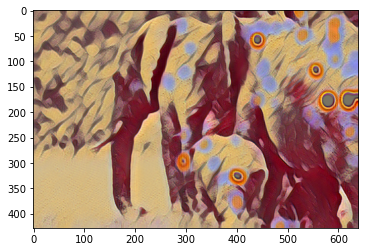

like 07_udnie.jpg Mon Feb 15 14:31:41 2021 [200/1000] content: 11.98  style: 976.95  reg: 0.00 total: 988.933777


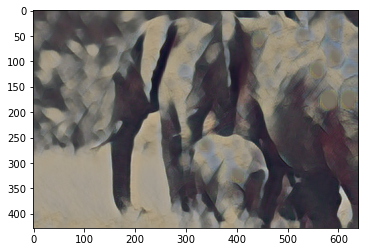

like 01_candy.jpg Mon Feb 15 14:32:47 2021 [300/1000] content: 12.85  style: 831.38  reg: 0.00 total: 844.234192


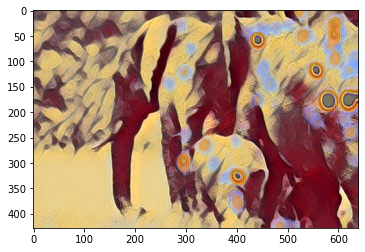

like 08_waterfall.jpg Mon Feb 15 14:33:54 2021 [400/1000] content: 13.39  style: 860.90  reg: 0.00 total: 874.296021


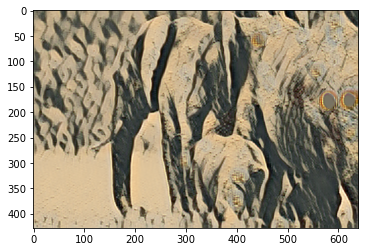

In [ ]:
CONTENT_WEIGHT = 1
#STYLE_WEIGHTS = np.array([1e-1, 1, 1e1, 5, 1e1]) * 1e4
STYLE_WEIGHTS = np.array([1e3]*5)
REGULARIZATION = 1e-6
LOG_INTERVAL = 100

LR = 1e-4
optimizer = Adam(transformer.parameters(), LR)
print(len(train_loader))
train(10000, 0)
save_model_path = "multistyle_11.pth"
torch.save(transformer.state_dict(), save_model_path)


In [33]:
from IPython.display import FileLink, FileLinks
FileLinks('./') #lists all downloadable files on server

./
  style.zip
  rain_unstable_vgg19.pth
  __notebook_source__.ipynb
  multistyle_11.pth
./style/
  07_udnie.jpg
  02_cezanne.jpg
  11_peppa.jpg
  06_starry-night-cropped.jpg
  05_rain-princess-cropped.jpg
  08_waterfall.jpg
  09_kandinsky.jpg
  04_picasso.jpg
  03_mosaic.jpg
  10_lisa.jpg
  01_candy.jpg

In [25]:
Path('./debug.zip').unlink()
!zip -r debug.zip ./debug

FileNotFoundError: [Errno 2] No such file or directory: 'debug.zip'

In [ ]:
print([f'{x:0>2d}' for x in range(0,120,14)])

In [ ]:
Image.fromarray(recover_image(img_output.data.cpu().numpy())[0])



transform = transforms.Compose([
                                transforms.Resize(IMAGE_SIZE),
                                transforms.ToTensor(),
                                tensor_normalizer()])
img_tensor = transform(img).unsqueeze(0)
if torch.cuda.is_available():
    img_tensor = img_tensor.cuda()

img_output = transformer(Variable(img_tensor, volatile=True))
Image.fromarray(recover_image(img_output.data.cpu().numpy())[0])


# In[36]:


img = Image.open("./content_images/amber.jpg").convert('RGB')
transform = transforms.Compose([
    transforms.Resize(512),
    transforms.ToTensor(),
    tensor_normalizer()])
img_tensor = transform(img).unsqueeze(0)
print(img_tensor.size())
if torch.cuda.is_available():
    img_tensor = img_tensor.cuda()

img_output = transformer(Variable(img_tensor, volatile=True))
plt.imshow(recover_image(img_tensor.cpu().numpy())[0])


# In[37]:


plt.imshow(recover_image(img_output.data.cpu().numpy())[0])


# In[38]:


img = Image.open("./content_images/amber.jpg").convert('RGB')
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    tensor_normalizer()])
img_tensor = transform(img).unsqueeze(0)
print(img_tensor.size())
if torch.cuda.is_available():
    img_tensor = img_tensor.cuda()

img_output = transformer(Variable(img_tensor, volatile=True))
plt.imshow(recover_image(img_output.data.cpu().numpy())[0])


# In[32]:


output_img = Image.fromarray(recover_image(img_output.data.cpu().numpy())[0])
output_img.save("amber.png")